In [1]:
# pytorch mlp for multiclass classification
from numpy import vstack
from numpy import argmax
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from tqdm import tqdm
from torch.nn import Dropout

In [2]:
path = pd.read_csv('/kaggle/input/machine-predictive-maintenance-classification/predictive_maintenance.csv')

In [3]:
path

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


In [4]:

print(path['Type'].unique())  #les valeurs de symbole
print(path['Target'].unique())  #les valeurs de symbole
print(path['Failure Type'].unique())  #les valeurs de symbole


['M' 'L' 'H']
[0 1]
['No Failure' 'Power Failure' 'Tool Wear Failure' 'Overstrain Failure'
 'Random Failures' 'Heat Dissipation Failure']


In [5]:
# Display basic information about the dataset
print(path.info())

# Display summary statistics
print(path.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
None
               UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930

In [6]:
# Check for missing values
print(path.isnull().sum())

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64


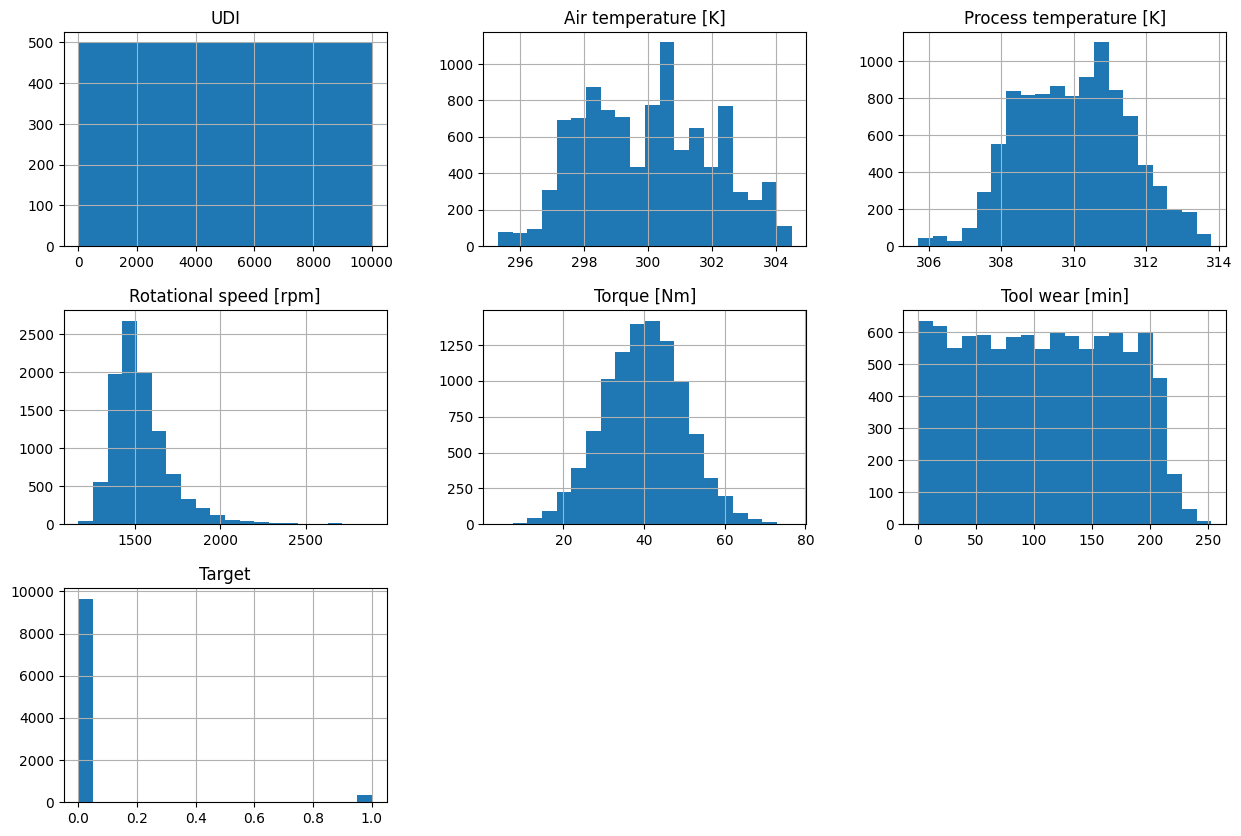

In [7]:
# Plot histograms for numeric columns
path.hist(bins=20, figsize=(15,10))
plt.show()

In [8]:
# dataset definition
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, path):
        # load the csv file as a dataframe
        df = read_csv(path, header=None , low_memory=False)
        # store the inputs and outputs
        self.X = df.values[1:, 3:8]
        self.y = df.values[1:, -1]
        # ensure input data is floats
        self.X = self.X.astype('float64')
        # label encode target and ensure the values are floats
        self.y = LabelEncoder().fit_transform(self.y)
        
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)

    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

    # get indexes for train and test rows
    def get_splits(self, n_test=0.33):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])

In [9]:
from torch.nn import Module, Linear, ReLU, Softmax, Dropout
from torch.nn.init import kaiming_uniform_, xavier_uniform_

class MLP(Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to the first hidden layer
        self.hidden1 = Linear(n_inputs, 10)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.dropout1 = Dropout(0.2)
        
        # second hidden layer
        self.hidden2 = Linear(10, 8)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        
        # third hidden layer and output
        self.hidden3 = Linear(8, 2)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Softmax(dim=1)

    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.dropout1(X) 
        
        X = self.hidden2(X)
        X = self.act2(X)
        
        X = self.hidden3(X)
        X = self.act3(X)
        return X

In [10]:
# prepare the dataset
def prepare_data(path):
    # load the dataset
    dataset = CSVDataset(path)
    # calculate split
    train, test = dataset.get_splits()
    # prepare data loaders
    train_dl = DataLoader(train, batch_size=1024, shuffle=True)
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)
    return train_dl, test_dl

In [11]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [12]:
number_epochs = 500 
learning_rate = 0.01
loss_per_epoch = []
loss_per_epoch_validation= []
# train the model
def train_model(train_dl, model):
    #desired_error = 10  # Set your desired error level
    #average_loss = 200
    # early stop patience
    patience = 7
    size = len(train_dl.dataset)
    # define loss function MSE 
    criterion = CrossEntropyLoss()
    # define the optimization ADAM 
    # regularization L2 = weight_decay
    optimizer =  Adam(model.parameters(), lr=learning_rate , weight_decay= 0.01)
    epoch = 0 
    # Early stop object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    # enumerate epochs
    #while(average_loss >= desired_error): # accroding to loss function do epochs 
    for epoch in tqdm(range(number_epochs),desc='Training Epochs'):
        print(f"Epoch {epoch+1}\n-------------------------------") # enumerate mini batches
        # training data 
        total_loss = 0.0
        model.train()
        TrainigStep_loss = []
        for batch, (inputs, targets) in enumerate(train_dl):
            
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            #print("y befor" , inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
            TrainigStep_loss.append(loss.item())
            #total_loss += loss.item()
        
        #average_loss = total_loss / len(train_dl)
        loss = np.array(TrainigStep_loss).mean()
        loss_per_epoch.append(loss)
        print(f"loss: {loss:>7f}")
        #print(f"Average loss :{average_loss:>7f}" )
        
        # test / validation data 
        model.eval()     # Optional when not using Model Specific layer
        validationStep_loss = []
        for batch, (inputs, targets) in enumerate(test_dl):
            
            # Forward Pass
            outputs = model(inputs)
            # Find the Loss
            validation_loss = criterion(outputs, targets)
            # Calculate Loss
            validationStep_loss.append(validation_loss.item())
            
        loss_per_epoch_validation.append(np.array(validationStep_loss).mean())
        
        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(TrainigStep_loss)
        valid_loss = np.average(validationStep_loss)
        
        # early stopping
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        '''
        early_stopper = EarlyStopper(patience=3, min_delta=10)
        if early_stopper.early_stop(np.array(loss_per_epoch_validation).mean()):  
            print("Early stop lunched " ,epoch )
            break
        '''
        #epoch+=1




In [13]:
# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        # convert to class labels
        yhat = argmax(yhat, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc

In [14]:
# make a class prediction for one row of data
def predict(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return yhat


In [15]:
# prepare the data
path = '/kaggle/input/machine-predictive-maintenance-classification/predictive_maintenance.csv'
train_dl, test_dl = prepare_data(path)
print(len(train_dl.dataset), len(test_dl.dataset))
# define the network
model = MLP(5)
# train the model
train_model(train_dl, model)

6700 3300


Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1
-------------------------------


RuntimeError: mat1 and mat2 must have the same dtype